# Unet masks with scaled rectangle, keeping image dimensions ratio masks

In [41]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

from wings.config import MODELS_DIR, RAW_DATA_DIR
from wings.dataset import MaskRectangleDataset
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess

countries = ['AT', 'GR', 'HR', 'HU', 'MD', 'PL', 'RO', 'SI']


In [2]:
square_size = 3
test_dataset = MaskRectangleDataset(countries, RAW_DATA_DIR, unet_fit_rectangle_preprocess, square_size=square_size)
max_n = len(test_dataset)
print(MaskRectangleDataset.__mro__)

100%|██████████| 21722/21722 [00:00<00:00, 73310.44it/s]

(<class 'wings.dataset.MaskRectangleDataset'>, <class 'wings.dataset.MasksDataset'>, <class 'wings.dataset.WingsDatasetRectangleImages'>, <class 'wings.dataset.WingsDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


In [42]:
checkpoint_path = MODELS_DIR / 'unet-epoch=05-val_loss=0.11-unet-training_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [3]:
image, mask, orig_labels, orig_size = test_dataset[0]
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8464988..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8464988..255.0].


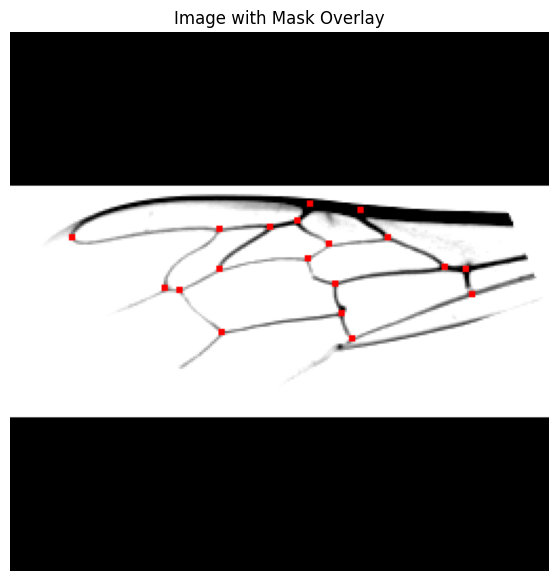

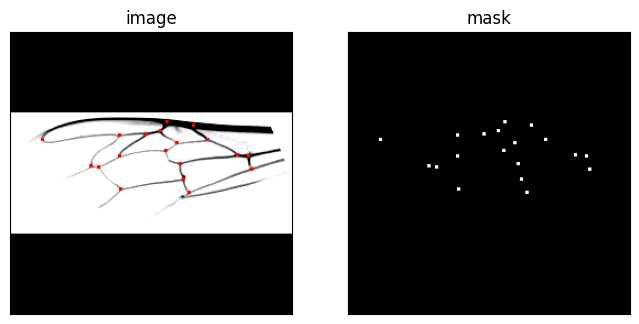

In [40]:
n = np.random.randint(0, max_n)
image, label, _, _ = test_dataset[n]

image_np = image.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

mask = torch.round(label).squeeze().detach().cpu().numpy()
labels = torch.round(label).squeeze().detach().cpu().numpy()

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 255, 0]
image_bgr[white_areas] = [0, 0, 255]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
# plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_rgb, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# Predykcje z modelu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7601283..255.0].


0.0


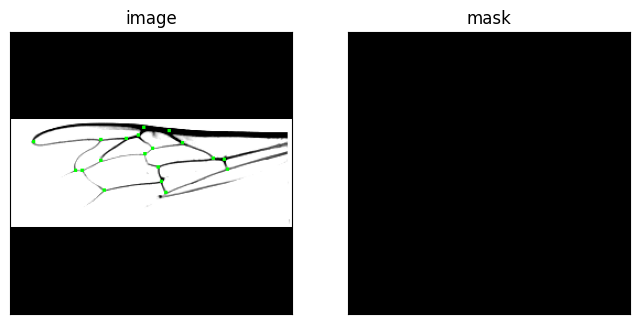

In [66]:
n = np.random.randint(0, max_n)
image, label, _, _ = test_dataset[n]

output = model(image.cuda().unsqueeze(0))

image_np = image.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

mask = torch.round(output).squeeze().detach().cpu().numpy()
print(mask.max())
labels = torch.round(label).squeeze().detach().cpu().numpy()

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 255, 0]
image_bgr[white_areas] = [0, 0, 255]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
# plt.figure(figsize=(7, 7))
# plt.imshow(image_rgb)
# plt.axis('off')
# plt.title("Image with Mask Overlay")
# plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_rgb, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()